In [1]:
from __future__ import division
import os
from tqdm import tqdm
from natsort import natsorted
import nibabel as nb
import statistics
# Opens data file and constructs features
def get_data(subdir):
    data = pd.DataFrame(columns=['mean', 'median', 'stdev'])
    for filename in tqdm(natsorted(os.listdir(subdir))):
        path = subdir + filename
        img = nb.load(path).get_data()[..., 0]
        hist = img[img > 0].flatten()
        data = data.append({'mean': hist.mean(),
                            'median': statistics.median(hist),
                            'stdev': statistics.stdev(hist),
                           }, ignore_index=True)
    return data

In [2]:
# Fetch data or open files with data
import pandas as pd
train_features = pd.DataFrame.from_csv('../data/train_data.csv')[["mean", "median", "gm", "age"]]
test_features = pd.DataFrame.from_csv('../data/test_data.csv')[["mean", "median", "gm"]]

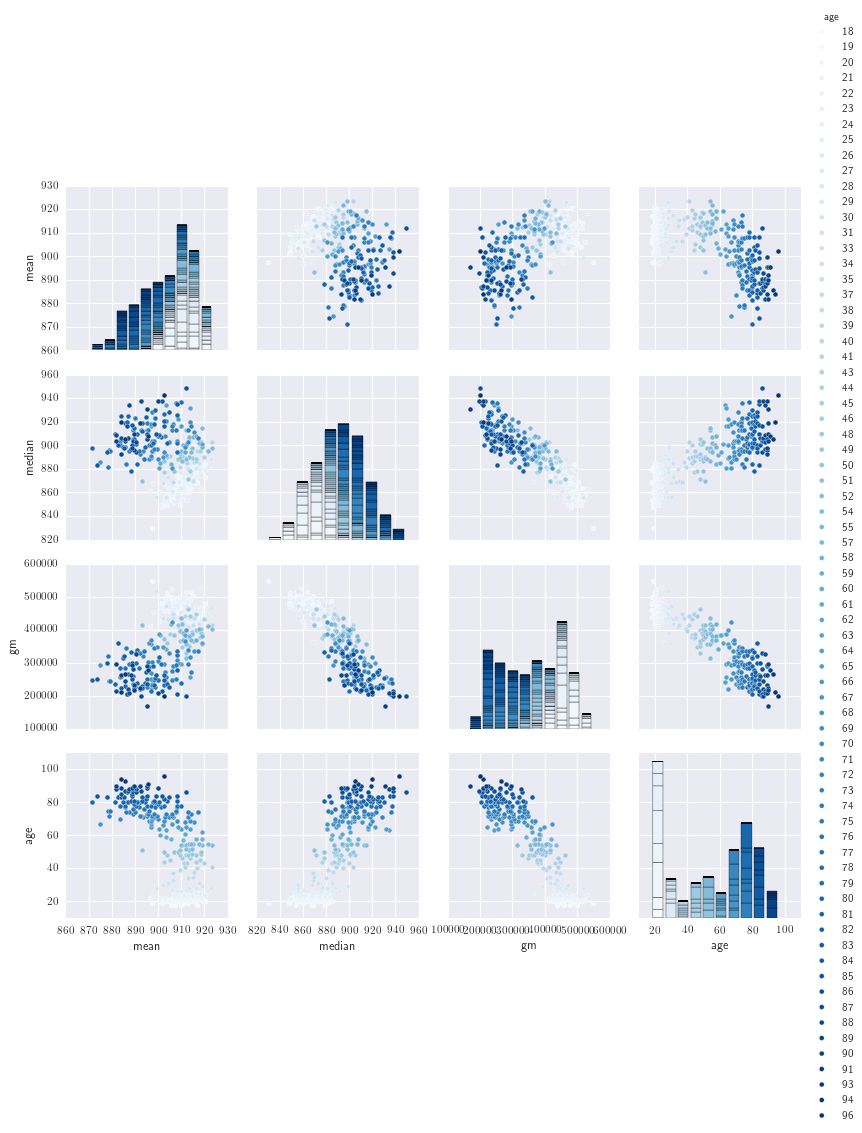

In [3]:
# Show pairwise relations between features
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(train_features, hue='age', palette='Blues')

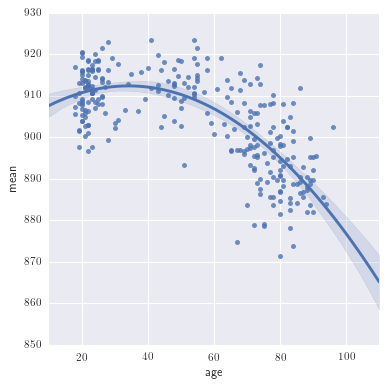

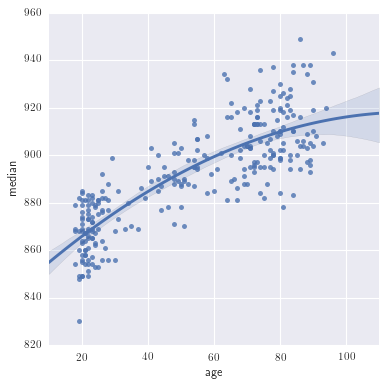

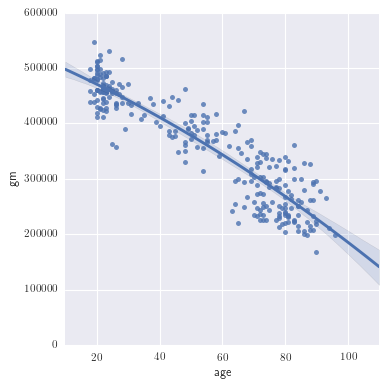

In [5]:
# Illustrate polynomial regression features vs. age
order = 2
sb.lmplot(y='mean', x='age', data=train_features, order=order)
sb.lmplot(y='median', x='age', data=train_features, order=order)
sb.lmplot(y='gm', x='age', data=train_features, order=order)

In [6]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
alpha = 40
order = 2
best_estimator_name, best_estimator, best_order, min_error = '', None, 0, 1000
# Train and test model
X = train_features.drop("age", axis=1).as_matrix()
y = train_features["age"].as_matrix()
kf = KFold(n_splits=5)
train_test_split = list(kf.split(X))
normalize = False
for order in range(1, 6):
    for alpha in range(50, 2001, 50):
        estimators = [
            ('LinearRegression', LinearRegression(normalize=normalize)),
            ('Ridge(alpha=%d)' % (alpha), Ridge(alpha=alpha, normalize=normalize)),
            ('Lasso(alpha=%d)' % (alpha), Lasso(alpha=alpha, normalize=normalize))
        ]
        for estimator_name, estimator in estimators:
            model = make_pipeline(PolynomialFeatures(order), estimator)
            errors = []
            for train, test in train_test_split:
                X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
                model.fit(X_train, y_train)                    
                predictions = model.predict(X_test)
                errors.append(mean_squared_error(y_test, predictions))
            errors_mean = sum(errors) / len(errors)
            print '%s [%d]: %f' % (estimator_name, order, errors_mean)
            if min_error > errors_mean:
                best_estimator_name = estimator_name
                best_estimator = estimator
                min_error = errors_mean
                best_order = order
            
print "\nBest result:"
print best_estimator_name, best_order, min_error

LinearRegression [1]: 84.856687
Ridge(alpha=50) [1]: 84.856802
Lasso(alpha=50) [1]: 105.530373
LinearRegression [1]: 84.856687
Ridge(alpha=100) [1]: 84.859349
Lasso(alpha=100) [1]: 105.530354
LinearRegression [1]: 84.856687
Ridge(alpha=150) [1]: 84.864217
Lasso(alpha=150) [1]: 105.530337
LinearRegression [1]: 84.856687
Ridge(alpha=200) [1]: 84.871298
Lasso(alpha=200) [1]: 105.530319
LinearRegression [1]: 84.856687
Ridge(alpha=250) [1]: 84.880493
Lasso(alpha=250) [1]: 105.530303
LinearRegression [1]: 84.856687
Ridge(alpha=300) [1]: 84.891705
Lasso(alpha=300) [1]: 105.530286
LinearRegression [1]: 84.856687
Ridge(alpha=350) [1]: 84.904841
Lasso(alpha=350) [1]: 105.530271
LinearRegression [1]: 84.856687
Ridge(alpha=400) [1]: 84.919814
Lasso(alpha=400) [1]: 105.530256
LinearRegression [1]: 84.856687
Ridge(alpha=450) [1]: 84.936538
Lasso(alpha=450) [1]: 105.530241
LinearRegression [1]: 84.856687
Ridge(alpha=500) [1]: 84.954934
Lasso(alpha=500) [1]: 105.530228
LinearRegression [1]: 84.856687


/home/abis_m/.pyenv/versions/2.7.9/lib/python2.7/site-packages/scikit_learn-0.18-py2.7-linux-x86_64.egg/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=50) [2]: 73.938098
LinearRegression [2]: 72.190534
Ridge(alpha=100) [2]: 70.736527
Lasso(alpha=100) [2]: 73.941909
LinearRegression [2]: 72.190534
Ridge(alpha=150) [2]: 70.734848
Lasso(alpha=150) [2]: 73.944375
LinearRegression [2]: 72.190534
Ridge(alpha=200) [2]: 70.733948
Lasso(alpha=200) [2]: 73.945163
LinearRegression [2]: 72.190534
Ridge(alpha=250) [2]: 70.733361
Lasso(alpha=250) [2]: 73.942471
LinearRegression [2]: 72.190534
Ridge(alpha=300) [2]: 70.732929
Lasso(alpha=300) [2]: 73.931327
LinearRegression [2]: 72.190534
Ridge(alpha=350) [2]: 70.732587
Lasso(alpha=350) [2]: 73.919597
LinearRegression [2]: 72.190534
Ridge(alpha=400) [2]: 70.732300
Lasso(alpha=400) [2]: 73.909836
LinearRegression [2]: 72.190534
Ridge(alpha=450) [2]: 70.732051
Lasso(alpha=450) [2]: 73.890680
LinearRegression [2]: 72.190534
Ridge(alpha=500) [2]: 70.731827
Lasso(alpha=500) [2]: 73.907233
LinearRegression [2]: 72.190534
Ridge(alpha=550) [2]: 70.731622
Lasso(alpha=550) [2]: 73.906213
LinearReg

In [7]:
best_order = 3
best_estimator = Ridge(alpha=1000)
best_estimator_name = "Ridge"
best_model = make_pipeline(PolynomialFeatures(best_order), best_estimator)
best_model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [8]:
predictions = best_model.predict(test_features)
predictions = [min(max(int(round(i)), 18), 96) for i in predictions]
result = pd.DataFrame({'ID': range(1, len(predictions)+1), 'Prediction': predictions})
print ''
result.to_csv('../data/result_%s-order-%d.csv' % (best_estimator_name, best_order), index=False)

In [10]:
print predictions

[57, 53, 46, 46, 76, 24, 36, 83, 28, 26, 56, 64, 30, 33, 18, 71, 86, 31, 69, 76, 41, 27, 21, 32, 23, 35, 38, 68, 32, 32, 48, 30, 58, 83, 18, 41, 19, 24, 18, 18, 84, 82, 63, 39, 31, 67, 25, 68, 84, 60, 83, 87, 30, 68, 88, 71, 46, 74, 18, 27, 77, 33, 70, 43, 18, 25, 24, 68, 83, 83, 64, 54, 87, 41, 70, 83, 29, 63, 56, 42, 30, 25, 75, 67, 23, 81, 19, 50, 30, 82, 75, 73, 19, 71, 59, 60, 77, 45, 56, 18, 31, 24, 29, 80, 76, 76, 83, 77, 18, 18, 78, 72, 49, 58, 56, 51, 32, 68, 80, 83, 33, 33, 83, 18, 47, 30, 57, 77, 25, 66, 45, 25, 67, 83, 65, 78, 63, 61]
